In [1]:
import pandas as pd
foxconndf= pd.read_csv('jpy2017-2019.csv', index_col=0 )
foxconndf.dropna(how='any',inplace=True)

In [2]:
from sklearn import preprocessing
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping
def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['spotbuyin'] = min_max_scaler.fit_transform(df.spotbuyin.values.reshape(-1,1))
    newdf['cashsellout'] = min_max_scaler.fit_transform(df.cashsellout.values.reshape(-1,1))
    newdf['spotsellout'] = min_max_scaler.fit_transform(df.spotsellout.values.reshape(-1,1))
    newdf['cashbuyin'] = min_max_scaler.fit_transform(df.cashbuyin.values.reshape(-1,1))
    
    return newdf

foxconndf_norm= normalize(foxconndf)

C:\Users\willy\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\willy\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\willy\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\willy\AppData\Roaming\Pyth

In [3]:
import numpy as np

def data_helper(df, time_frame):
    
    # 資料維度: 5維
    number_features = len(df.columns)

    # 將dataframe 轉成 numpy array
    datavalue = df.as_matrix()

    result = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance
    
    result = np.array(result)
    number_train = round(0.90 * result.shape[0]) # 取 result 的前90% instance做為訓練資料
    
    x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    
    # 測試資料
    x_test = result[int(number_train):, :-1]
    y_test = result[int(number_train):, -1][:,-1]
    
    # 將資料組成變好看一點
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))  

    return [x_train, y_train, x_test, y_test]

# 以20天為一區間進行股價預測
X_train, y_train, X_test, y_test = data_helper(foxconndf_norm, 5)


C:\Users\willy\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras
from keras.layers.embeddings import Embedding
def build_model(input_length, input_dim):
    d = 0.2
    model = Sequential()
   # model.add(Embedding(output_dim=32,
    #                    input_dim=1,
     #                  input_length=10))
   # model.add(Dropout(0.2))
    model.add(LSTM(1024, input_shape=(input_length, input_dim), return_sequences=True,kernel_regularizer=l2(0.01)))

    model.add(LSTM(1024, return_sequences=False))
    #model.add(Dropout(d))
    model.add(Dense(256,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(128,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(64,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(4,kernel_initializer="uniform",activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

    return model

# x天、x維
model = build_model( 5,4)

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 1024)           4214784   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [6]:
# 一個batch有128個instance，總共跑50個迭代
model.fit( X_train, y_train, batch_size=128, epochs=100, validation_split=0.001, verbose=1)


Train on 665 samples, validate on 1 samples
Epoch 1/100
665/665 [==============================] - 5s 7ms/step - loss: 0.1947 - accuracy: 0.0015 - val_loss: 0.4473 - val_accuracy: 0.0000e+00
Epoch 2/100
665/665 [==============================] - 3s 5ms/step - loss: 0.1629 - accuracy: 0.0015 - val_loss: 0.4176 - val_accuracy: 0.0000e+00
Epoch 3/100
665/665 [==============================] - 4s 5ms/step - loss: 0.1401 - accuracy: 0.0015 - val_loss: 0.3962 - val_accuracy: 0.0000e+00
Epoch 4/100
665/665 [==============================] - 3s 5ms/step - loss: 0.1247 - accuracy: 0.0015 - val_loss: 0.3805 - val_accuracy: 0.0000e+00
Epoch 5/100
665/665 [==============================] - 3s 5ms/step - loss: 0.1145 - accuracy: 0.0015 - val_loss: 0.3682 - val_accuracy: 0.0000e+00
Epoch 6/100
665/665 [==============================] - 3s 5ms/step - loss: 0.1072 - accuracy: 0.0015 - val_loss: 0.3559 - val_accuracy: 0.0000e+00
Epoch 7/100
665/665 [==============================] - 3s 5ms/step - loss

665/665 [==============================] - 3s 5ms/step - loss: 0.0033 - accuracy: 0.0015 - val_loss: 7.7768e-04 - val_accuracy: 0.0000e+00
Epoch 55/100
665/665 [==============================] - 3s 5ms/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 4.1856e-04 - val_accuracy: 0.0000e+00
Epoch 56/100
665/665 [==============================] - 3s 5ms/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 3.6283e-04 - val_accuracy: 0.0000e+00
Epoch 57/100
665/665 [==============================] - 3s 5ms/step - loss: 0.0043 - accuracy: 0.0015 - val_loss: 4.9327e-04 - val_accuracy: 0.0000e+00
Epoch 58/100
665/665 [==============================] - 4s 5ms/step - loss: 0.0038 - accuracy: 0.0015 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 59/100
665/665 [==============================] - 4s 5ms/step - loss: 0.0034 - accuracy: 0.0015 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 60/100
665/665 [==============================] - 4s 5ms/step - loss: 0.0034 - accuracy: 0.0015 - val_l

In [7]:
def denormalize(df, norm_value):
    original_value = df['cashbuyin'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

# 用訓練好的 LSTM 模型對測試資料集進行預測
pred = model.predict(X_test)

# 將預測值與正確答案還原回原來的區間值
denorm_pred = denormalize(foxconndf, pred)
denorm_ytest = denormalize(foxconndf, y_test)

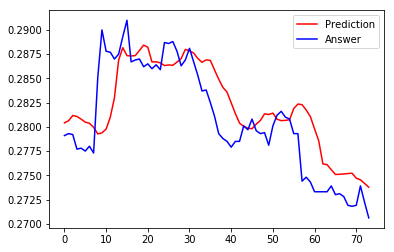

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()